In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.layers import MaxPool2D, Conv2D, Flatten, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
#from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [2]:
# Reading whole data saved in npz format
EEG_data_and_labels = np.load("C:/Users/vinay/Downloads/FEIS_v1_1/experiments/combined_data.npz")

# creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# perform one-hot encoding on 'labels' column 
one_hot_encoded_labels = encoder.fit_transform(EEG_data_and_labels["labels"].reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(EEG_data_and_labels["data"], one_hot_encoded_labels, test_size=0.2, random_state=42)

In [3]:
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

# The Sequential model is a linear stack of layers.
tf.keras.backend.clear_session()
model = Sequential()

# the authors of Batch Normalization say that It should be applied immediately before the non-linearity of the current layer
# Use the keyword argument input_shape when using this layer as the first layer in a model.
model.add(BatchNormalization(input_shape=(14,256,1)))

# detailed explanation https://keras.io/api/layers/convolution_layers/convolution2d/
model.add(Conv2D(32, kernel_size = (1,4), activation='relu'))
model.add(Conv2D(64, kernel_size = (14,1), activation='relu'))

# detailed explanation https://keras.io/api/layers/pooling_layers/max_pooling2d/
model.add(MaxPool2D(pool_size=(1, 4) , strides= 3))

model.add(Conv2D(64, kernel_size = (1,4), activation='relu'))
#model.add(Reshape((50,6,1), input_shape=(1,6,50)))
#model.add(Reshape((50,78,1), input_shape=(1,78,50)))
#model.add(MaxPool2D(pool_size=(1,3) , strides= None))
#model.add(Conv2D(100, kernel_size = (50,2), activation='relu'))

# Flatten the inputs
model.add(Flatten())

# detailed explanation https://keras.io/api/layers/core_layers/dense/
model.add(Dense(500, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(Dropout(0.5)) # Fraction of the input units to drop
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(16, activation = 'softmax'))

# Configures the model for training.
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [4]:
# Creating instance of CSVlogger
csv_logger = CSVLogger("./model_history/model_acc_loss_5.csv")

# Saving model layers in text file
with open('./model_history/model_summary_5.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [5]:
# Fit the model
history = model.fit(X_train, y_train, validation_data =(X_test, y_test) , callbacks=[csv_logger], verbose=1, epochs = 30, batch_size = 50)

Epoch 1/30
265/265 [==============================] - 37s 127ms/step - loss: 3.5813 - accuracy: 0.0626 - val_loss: 4.2893 - val_accuracy: 0.0568
Epoch 2/30
265/265 [==============================] - 33s 123ms/step - loss: 3.2596 - accuracy: 0.0615 - val_loss: 3.0850 - val_accuracy: 0.0580
Epoch 3/30
265/265 [==============================] - 33s 125ms/step - loss: 3.1100 - accuracy: 0.0600 - val_loss: 3.0107 - val_accuracy: 0.0589
Epoch 4/30
265/265 [==============================] - 34s 128ms/step - loss: 3.0129 - accuracy: 0.0672 - val_loss: 2.9562 - val_accuracy: 0.0568
Epoch 5/30
265/265 [==============================] - 34s 127ms/step - loss: 2.9576 - accuracy: 0.0640 - val_loss: 2.9164 - val_accuracy: 0.0553
Epoch 6/30
265/265 [==============================] - 34s 128ms/step - loss: 2.9175 - accuracy: 0.0610 - val_loss: 2.8904 - val_accuracy: 0.0543
Epoch 7/30
265/265 [==============================] - 36s 134ms/step - loss: 2.8874 - accuracy: 0.0621 - val_loss: 2.8702 - val_ac

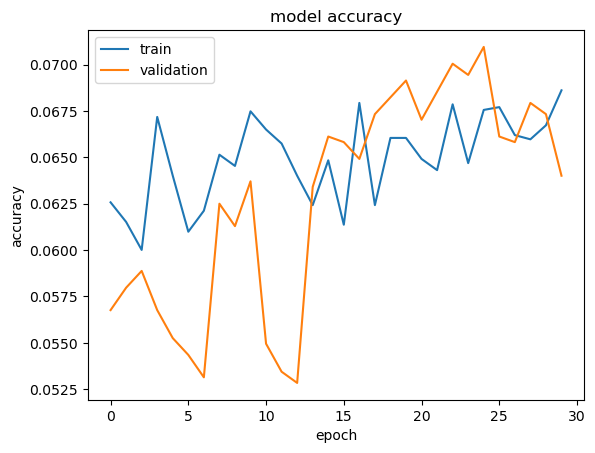

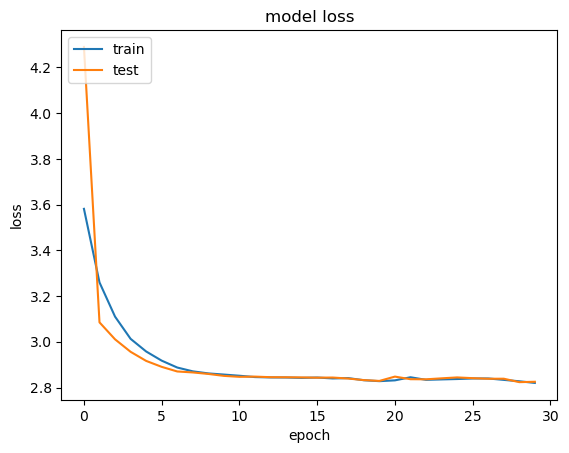

In [51]:
# summarize history for accuracy
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confusion matrix for training data

In [46]:
def predict_image(inputs, model):
    # Get predictions from model
    yb = model(inputs)
    yb_arr = yb.numpy()
    return yb_arr.argmax()

reference_labels = ['f', 'fleece', 'goose', 'k', 'm', 'n', 'ng', 'p', 's', 'sh', 't', 'thought', 'trap', 'v', 'z', 'zh']
y_pred = []


# iterate over test data
for inputs in X_train:
    inputs = np.asarray(inputs)
    inputs = np.expand_dims(inputs, axis=2)
    inputs = inputs[None, :]
    y_pred.append(predict_image(inputs, model))

y_true = []
for i in y_train:
    y_true.append(i.argmax())

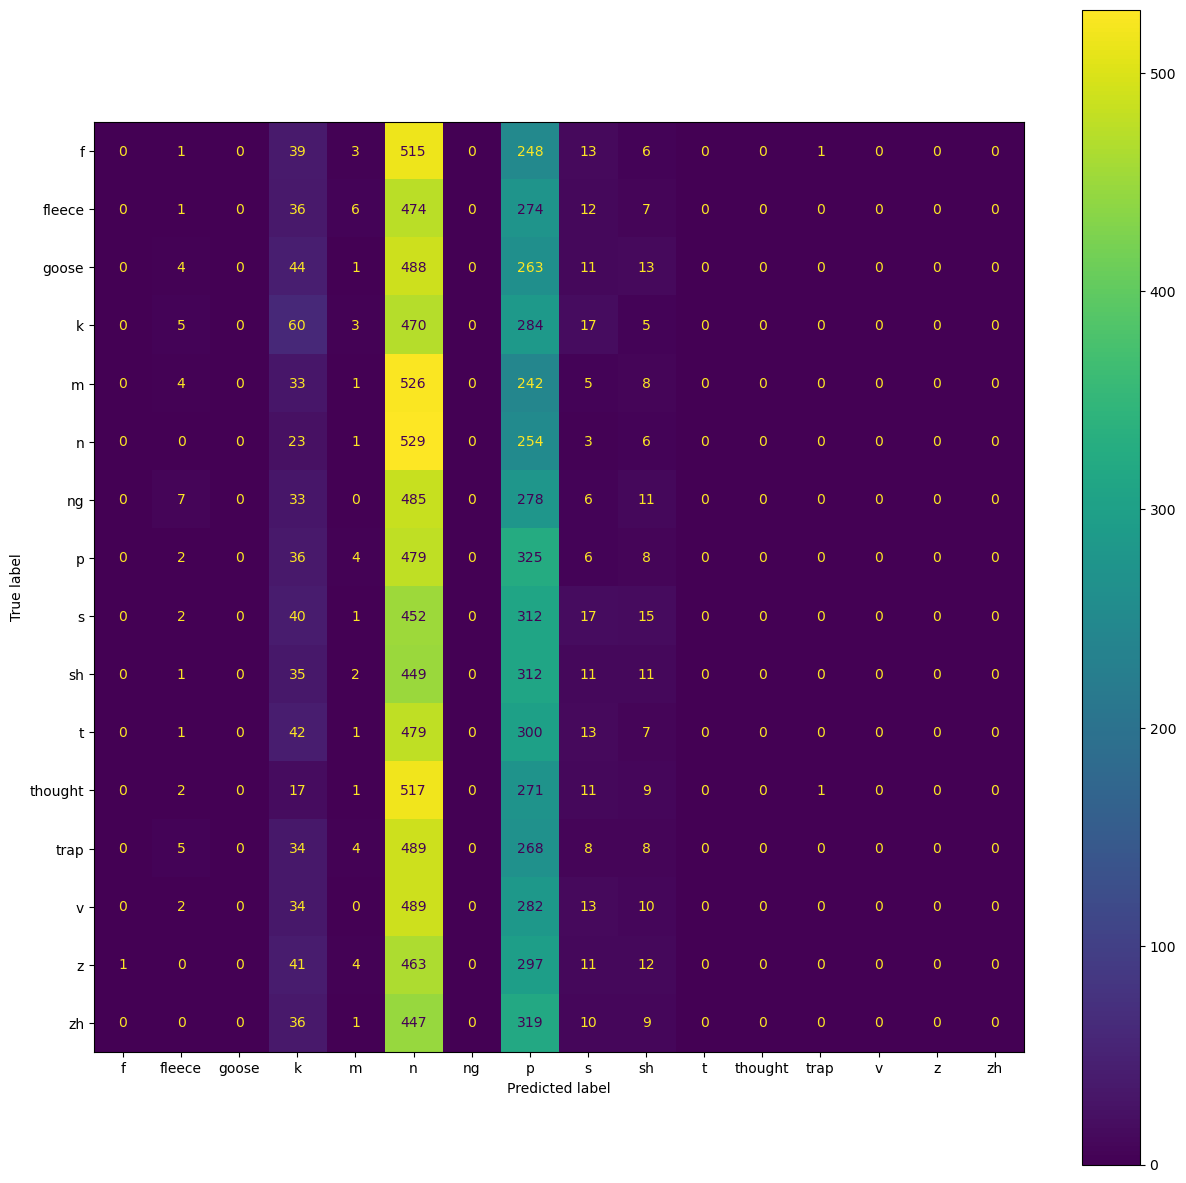

In [47]:
cf_matrix = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['f', 'fleece', 'goose', 'k', 'm', 'n', 'ng', 'p', 's', 'sh', 't', 'thought', 'trap', 'v', 'z', 'zh'])
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax)

## Confusion matrix for validation/ testing data

In [48]:
def predict_image(inputs, model):
    # Get predictions from model
    yb = model(inputs)
    yb_arr = yb.numpy()
    return yb_arr.argmax()

reference_labels = ['f', 'fleece', 'goose', 'k', 'm', 'n', 'ng', 'p', 's', 'sh', 't', 'thought', 'trap', 'v', 'z', 'zh']
y_pred = []


# iterate over test data
for inputs in X_test:
    inputs = np.asarray(inputs)
    inputs = np.expand_dims(inputs, axis=2)
    inputs = inputs[None, :]
    y_pred.append(predict_image(inputs, model))

y_true = []
for i in y_test:
    y_true.append(i.argmax())

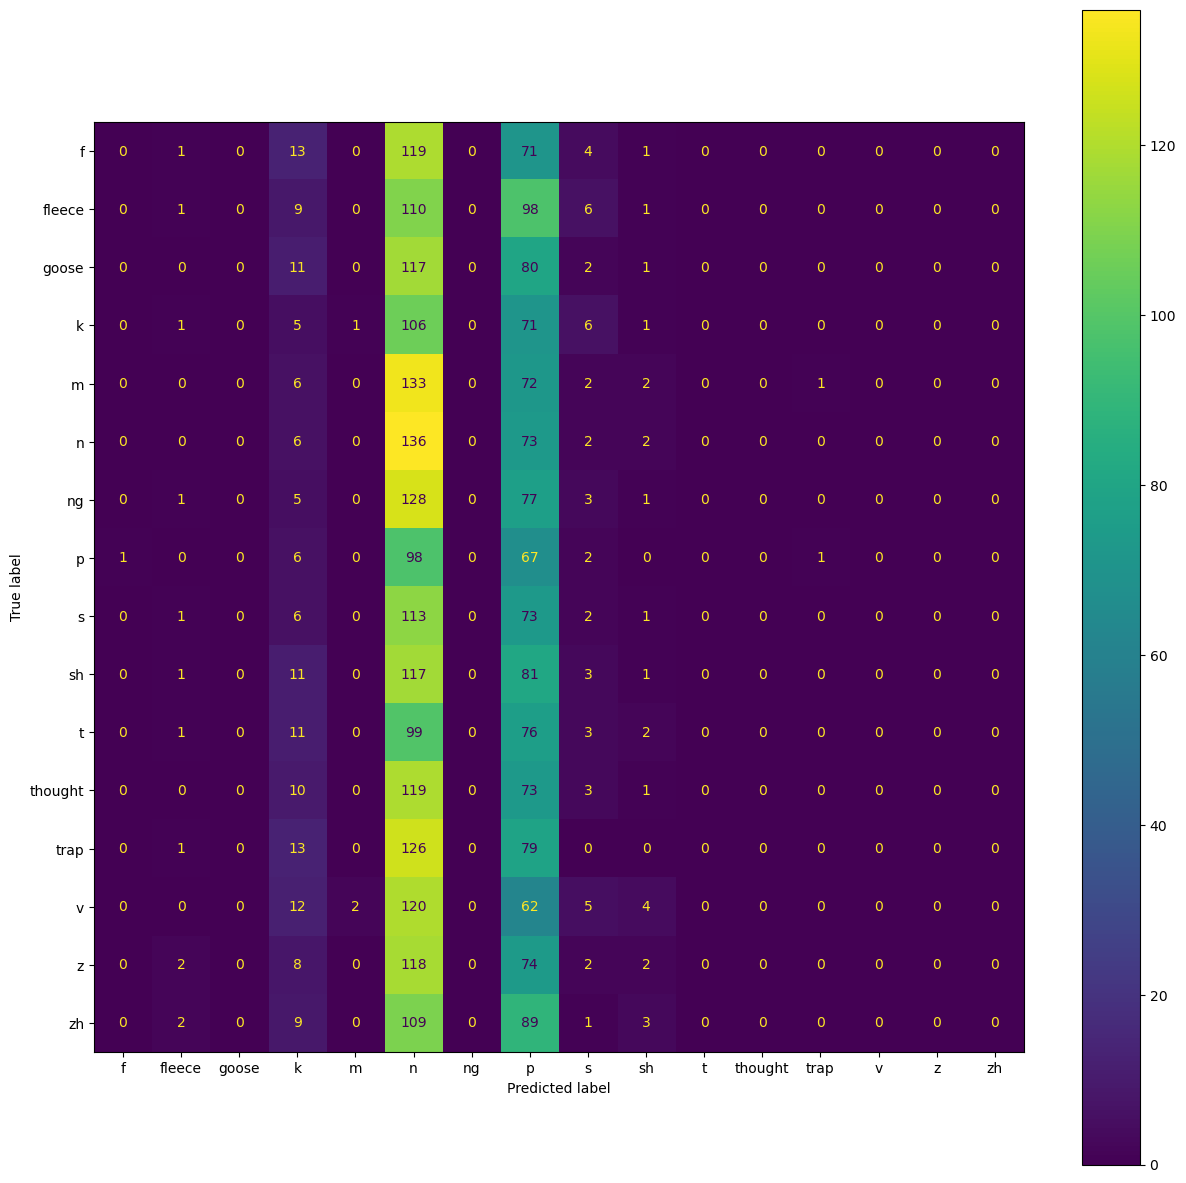

In [49]:
cf_matrix = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['f', 'fleece', 'goose', 'k', 'm', 'n', 'ng', 'p', 's', 'sh', 't', 'thought', 'trap', 'v', 'z', 'zh'])
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax)

In [ ]:
"""
filepath="/model_history/net_dc.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history=model.fit(X_train, y_train, validation_data =(X_test, y_test) , callbacks=callbacks_list, verbose=1, epochs = 5, batch_size = 50)
#Load and evaluate the best model version
model = load_model(filepath)
yhat = model.predict(X_test)
print('Model MSE on test data = ', mse(y_test, yhat).numpy())

from tensorflow.keras import callbacks
callbacks.ModelCheckpoint(
     filepath='model.{epoch:02d}-{val_loss:.4f}.h5', 
     save_freq='epoch', verbose=1, monitor='val_loss', 
     save_weights_only=True, 
)

checkpoint_filepath = './checkpoints2/checkpoint_default'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, mode="auto", save_freq=1, save_weights_only=True)

"""